In [58]:
# Goal: t-SNE MAP; term co-occurrence NETWORK/TREE

# Helper libraries
import pandas as pd
import numpy as np

# Dimensionality reduction (topic model, embedding)
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Random seed set for reproducbility
import random 
random.seed(13)

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [12]:
# DATA Read in documents (articles, projects) from csv; combine title and abstract for topic model
# TO DO: check/drop duplicates by title
print("Loading documents")
print(len(df))
df = pd.read_csv("data/ERI-combined-full-2009-2019.csv")
df['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
df.head()

Loading documents
3770


,id,start_year,end_year,title,abstract,type,authors,identifier,combined
0,0a,2019,2019,"Proteomic, gene and metabolite characterizatio...",Cadmium sulfide quantum dots regulate nanomate...,article,"Majumdar, Sanghamitra; Pagano, Luca; Wohlschle...",10.1039/c9en00599d,"Proteomic, gene and metabolite characterizatio..."
1,1000a,2014,2014,Evaluation of Aquarius Level 2 Soil Moisture P...,Validation is important for any satellite-base...,article,"Li, Dongyang; Zhao, Tianjie; Shi, Jiancheng; B...",10.1109/igarss.2014.6946966,Evaluation of Aquarius Level 2 Soil Moisture P...
2,1001a,2014,2014,Fusion of Space-Based CO2 Products and its Com...,"Currently, ascertaining and quantifying the gl...",article,"Jing, Yingying; Shi, Jiancheng; Wang, Tianxing",10.1109/igarss.2014.6946946,Fusion of Space-Based CO2 Products and its Com...
3,1002a,2014,2014,Water Vapor Retrieval Over Cloud Cover Area on...,This study mainly discusses atmospheric water ...,article,"Ji, Dabin; Shi, Jiancheng",10.1109/jstars.2014.2298979,Water Vapor Retrieval Over Cloud Cover Area on...
4,1003a,2014,2014,Toward Accurate XCO2 Level 2 Measurements by C...,Carbon dioxide (CO2) is one of the most import...,article,"Jing, Yingying; Wang, Tianxing; Shi, Jiancheng",10.1109/eorsa.2014.6927857,Toward Accurate XCO2 Level 2 Measurements by C...


In [19]:
# TOPIC MODEL define number of features, topics (based on grid search coherence scores) to get keywords for topics
# To do: text lemmatization, ngrams
n_features = 1000
n_topics = 9
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
        
custom_stop_words = []
#with open( "mallet-2.0.8/stoplists/en-custom.txt", "r" ) as fin: #load custom stop word list
with open( "mallet-2.0.8/stoplists/en-custom.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )

# vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['combined'])
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (tfidf.shape[0], tfidf.shape[1]) )

nmf = NMF(n_components=n_topics, init="nndsvd", random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)

# apply the model and extract the two factor matrices (W, H)
W = nmf.fit_transform( tfidf ) # W factor contains the document membership weights relative to each of the k topics
#W[0,:].round(2)

H = nmf.components_ # H factor contains the term weights relative to each of the k topics
#term_index = terms.index('climate') # test and see topic(s) associated with term "climate"
#H[:,term_index].round(2)

print("Topics found via NMF:")

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Created 3770 X 1000 TF-IDF-normalized document-term matrix
Topics found via NMF:

Topic #0:
water environmental model based management fire land energy analysis spatial


Topic #1:
ma mantle crust rocks crustal zircon pb metamorphism subduction metamorphic


Topic #2:
snow swe cover water snowmelt modis model equivalent snowpack microwave


Topic #3:
soil moisture microbial vegetation soils plant microwave surface dry water


Topic #4:
climate change precipitation adaptation future impacts warming variability land global


Topic #5:
species plant diversity native richness habitat biomass biodiversity communities ecosystem


Topic #6:
fault slip earthquake rupture seismic faults motion earthquakes ground velocity


Topic #7:
sediment erosion rates 10be river ice channel basin fluvial glacial


Topic #8:
ocean carbon co2 phytoplankton global color optical organic export surface



In [62]:
# TOPIC MODEL transform tfidf-matrix into nmf-embedding to find document titles/authors most associated per topic
nmf_embedding = nmf.transform(tfidf)

top_idx = np.argsort(nmf_embedding,axis=0)[-5:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(df.iloc[idx]['title'])  
        print(df.iloc[idx]['authors'])
    count += 1


Topic 0:
Urban water infrastructure optimization to reduce environmental impacts and costs
Lim, Seong-Rin; Suh, Sangwon; Kim, Jung-Hoon; Park, Hung Suck
35S The Ideal Tracer of Travel Time Near Mar Operations
Jordan Clark
Legal Economic Data and Analysis of Environmental Markets
Gary Libecap; Christopher Costello; Andrew Plantinga; Olivier Deschenes; Paulina Oliva Vallejo; Kyle Meng
Incorporating Water Quality and Quantity in Water-Use Impact Assessment Modeling for Life Cycle Assessment: With Case Studies of Coal and Natural Gas-powered Electricity Generation
Sangwon Suh
Evaluation of water use for bioenergy at different scales
Yeh, Sonia; Berndes, G  ran; Mishra, Gouri S.; Wani, Suhas P.; Neto, Andr   Elia; Suh, Sangwon; Karlberg, Louise; Heinke, Jens; Garg, Kaushal K.

Topic 1:
Timescales of development of sub-ophiolite subduction: High precision U-Pb dating and geochemical characterization of late magmatism and metamorphism in the Oman-U.A.E. ophiolite
Matthew Rioux
Time Scales of

In [22]:
# TOPIC MODEL optional - assign arbitrary labels to topics to assess embedding and mapping results
topics = ['environmental management',
          'solid earth',
          'mountain hydrology',
          'soil moisture',
          'climate change',
          'conservation ecology',
          'seismic hazards',
          'physical geography and geology', 
          'ocean biogeochemistry']

In [53]:
# VISUALIZE topics over time; initialize embedding
# TO DO: refine perplexity (5-50), early_exaggeration (default: 12.0)
tsne = TSNE(perplexity=7, early_exaggeration=5, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)
print("Documents to be embedded and visualized:")
print(len(tsne_embedding))
tsne_embedding.head()

Documents to be embedded and visualized:
3770


,x,y,hue
0,6.928870,5.414817,0
1,-9.617218,-98.582298,3
2,61.725323,-41.247910,8
3,-10.253021,-25.716450,0
4,68.798599,-28.033306,8


In [54]:
# VISUALIZE optional - create legend with custom symbology
# plt.style.use('ggplot')

# fig, axs = plt.subplots(1,1, figsize=(5, 5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .1, wspace=.001)

# legend_list = []

# data = tsne_embedding
# scatter = plt.scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="Set1")
# plt.axis('off')
# plt.show()

# colors = []
# for i in range(len(topics)):
#     idx = np.where(data['hue']==i)[0][0]
#     color = scatter.get_facecolors()[idx]
#     colors.append(color)
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

# colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
#  [ 0.22685121,  0.51898501,  0.66574396,  1. ],
#  [ 0.38731259,  0.57588621,  0.39148022,  1. ],
#  [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
#  [ 1.        ,  0.78937332,  0.11607843,  1. ],
#  [ 0.75226453,  0.52958094,  0.16938101,  1. ],
#  [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
#  [ 0.60000002,  0.60000002,  0.60000002,  1. ],
#  [ 1,  0.74211076,  0.0944053,  1. ]])

# legend_list = []

# for i in range(len(topics)):   
#     color = colors[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

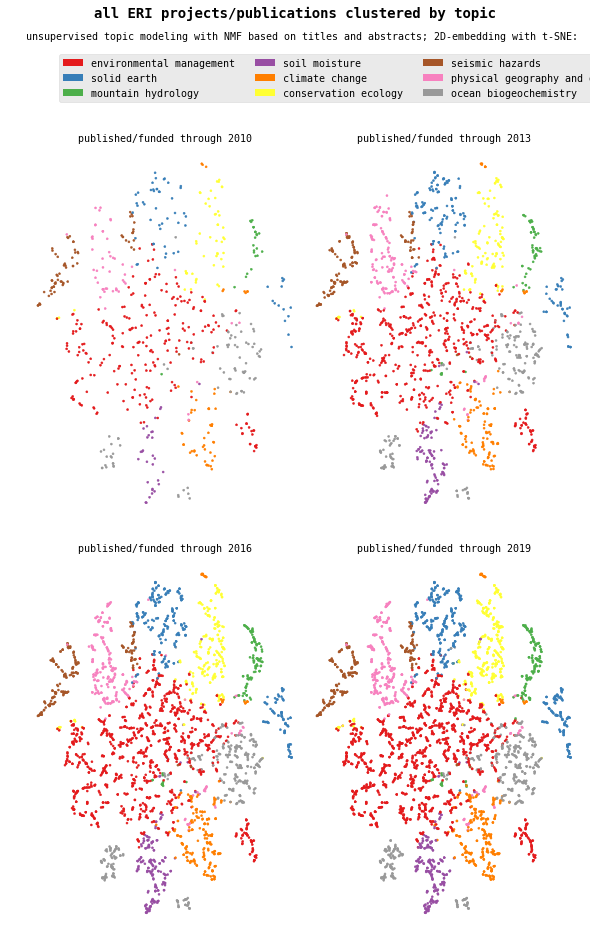

In [63]:
# VISUALIZE show documents clustered by topic and color-coded by most-representative topic
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

fig, axs = plt.subplots(2,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([2010,2013,2016,2019], range(4)):
    data = tsne_embedding[df['start_year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="Set1")
    axs[idx].set_title('published/funded through {}'.format(year),**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("all ERI projects/publications clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on titles and abstracts; 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')

fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()